In [1]:
import dataset

train_loader_dict, test_loader = dataset.make_train_test_datasets(dataset="mnist", num_labels=10, 
                                alpha_dirichlet= 10, num_nodes=16, train_batch=64, test_batch=100)

def count_elements(dataloader):
    count = 0
    for X, y in dataloader:
        count += len(y)
    return count

for i in range(len(train_loader_dict)):
    print(count_elements(train_loader_dict[i]))

5.6%

100.0%


Extracting /root/CD-SGD/datasets/cache/MNIST/raw/train-images-idx3-ubyte.gz to /root/CD-SGD/datasets/cache/MNIST/raw


100.0%


Extracting /root/CD-SGD/datasets/cache/MNIST/raw/train-labels-idx1-ubyte.gz to /root/CD-SGD/datasets/cache/MNIST/raw



100.0%


Extracting /root/CD-SGD/datasets/cache/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/CD-SGD/datasets/cache/MNIST/raw



100.0%


Extracting /root/CD-SGD/datasets/cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/CD-SGD/datasets/cache/MNIST/raw

Proportions for label 1 [0.0674734  0.11258481 0.06823908 0.04459326 0.10154952 0.0493773
 0.05929911 0.0616702  0.05761078 0.05428442 0.03679206 0.04187446
 0.05939473 0.05857774 0.06872021 0.05795893]
3600
4015
3927
3409
3854
3988
3414
3658
2993
3997
3100
3591
3475
4510
4460
3930


In [21]:
import worker, evaluator, torch, misc, dataset

num_nodes = 16
model = "libsvm_model"
dataset_name = "libsvm"
loss = "BCELoss"
num_nodes = 16
num_labels = 2
alpha = 10.
delta = 1e-5
epsilons = [1, 3, 5, 7, 15, 20, 25, 30, 40]
min_loss = 0.3236 # found in train_libsvm_bce.ipynb
criterion = "libsvm_topk"
device = "cuda"

train_loader_dict, test_loader = dataset.make_train_test_datasets(dataset=dataset_name, num_labels=num_labels, 
                                alpha_dirichlet= alpha, num_nodes=num_nodes, train_batch=64, test_batch=100)
# Initialize Workers
server = evaluator.Evaluator(train_loader_dict, test_loader, model, loss, num_labels, criterion, num_evaluations= 100, device=device)

workers = []
for i in range(num_nodes):
    data_loader = train_loader_dict[i]
    worker_i = worker.Worker(train_data_loader=data_loader, test_data_loader=test_loader, batch_size=64, 
                model = model, loss = loss, momentum = 0, gradient_clip= 0.1, sigma= 0.1,
                num_labels= num_labels, criterion= criterion, num_evaluations= 100, device = "cuda", privacy = "user")
    # Agree on first parameters
    worker_i.flat_parameters = server.flat_parameters
    worker_i.update_model_parameters()
    workers.append(worker_i)

# Noise tensor: shape (num_nodes, num_nodes, model_size)
V = torch.randn(num_nodes, num_nodes, workers[0].model_size) # distribution N(0, 1)
V.mul_(0.01) # rescaling ==> distribution N (0, sigma_cor^2)

# Antisymmetry property
V1 = misc.to_antisymmetric(V)

Proportions for label 1 [0.13331939 0.03266425 0.02967796 0.05627186 0.02670789 0.06792072
 0.04316031 0.09579974 0.05691413 0.05870648 0.09397451 0.04732806
 0.04041019 0.07741819 0.1056082  0.03411811]


In [13]:
(V[1] == -V[:, 1]).sum()
V[0].shape

torch.Size([16, 124])

In [14]:
V[:, 0].shape

torch.Size([16, 124])

In [26]:
def to_antisymmetric(tensor):
    # tensor is of shape (n, n, d)
    # Extract the lower triangular part
    new_tensor = tensor.clone()
    lower_indices= [(i, j) for i in range(1, new_tensor.shape[0]) for j in range(i)]
    print(lower_indices)
    # Convert the lists of indices to LongTensors
    indices_1 = torch.LongTensor(lower_indices)

    # Use indexing and assignment to perform t[l_1] = t[l_2]
    new_tensor[indices_1[:, 1], indices_1[:, 0]] = - new_tensor[indices_1[:, 0], indices_1[:, 1]]
    return new_tensor

In [27]:
V = to_antisymmetric(V)

[(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (12, 8), (12, 9), (12, 10), (12, 11), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (13, 8), (13, 9), (13, 10), (13, 11), (13, 12), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7), (15, 8), (15, 9),

In [32]:
(V[4, 8] == -V[8, 4]).all()

tensor(True)

In [36]:
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if (V[i, j] != -V[j, i]).sum() != 0:
            print("NOOO")
print("Nice")

Nice


In [37]:
import numpy as np 
np.logspace(-5, -1, 5)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

In [7]:
train_loader_dict, test_loader = dataset.make_train_test_datasets(dataset="mnist", num_labels=10, 
                                alpha_dirichlet= 1000, num_nodes=16, train_batch=64, test_batch=100)
s = 0
for i in range(len(train_loader_dict)):
    c = count_elements(train_loader_dict[i])
    print(c)
    s += c
print(s)

Proportions for label 1 [0.06156412 0.06446907 0.06303828 0.06425248 0.0618228  0.0613195
 0.06404928 0.06132321 0.06537084 0.05890092 0.06317416 0.06259525
 0.06039699 0.06093302 0.06387691 0.06291317]
3723
3734
3774
3730
3758
3760
3833
3702
3766
3710
3723
3731
3691
3752
3758
3773
59918


In [6]:
from utils import topology, dp_account
import numpy as np
import misc, torch

num_nodes = 16
sigma_cor = 1

W = topology.FixedMixingMatrix(topology_name= "grid", n_nodes= 16)(0)
adjacency_matrix = np.array(W != 0, dtype=float)
adjacency_matrix = adjacency_matrix - np.diag(np.diag(adjacency_matrix))
degree_matrix = np.diag(adjacency_matrix @ np.ones_like(adjacency_matrix[0]))

W = torch.tensor(W, dtype= torch.float)
# Noise tensor: shape (num_nodes, num_nodes, model_size)
V = torch.randn(num_nodes, num_nodes, 3) # distribution N(0, 1)
V.mul_(sigma_cor) # rescaling ==> distribution N (0, sigma_cor^2)

# Antisymmetry property and neighbours
V = misc.to_antisymmetric(V, W)
print(V[0])


tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.2553, -0.0380, -0.2279],
        [ 0.0000, -0.0000,  0.0000],
        [-0.2513, -0.0448,  0.1771],
        [ 0.2182, -0.2342,  0.2579],
        [-0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000],
        [-0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000],
        [-0.0236, -0.0547,  0.1812],
        [-0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000]])


In [12]:
# Test
for i in range(num_nodes):
    # diag part
    if not torch.all(V[i, i].eq(0)):
        print("We have a non null part of diagonal")
    for j in range(num_nodes):
        # antisymmetric part 
        if not torch.equal(V[i, j], - V[j, i]):
            print("not antisymmetric")
        # neighbors part
        if W[i, j] == 0:
            if not torch.all(V[i, j].eq(0)):
                print("neighbours part not verified")
print("Cool")

Cool


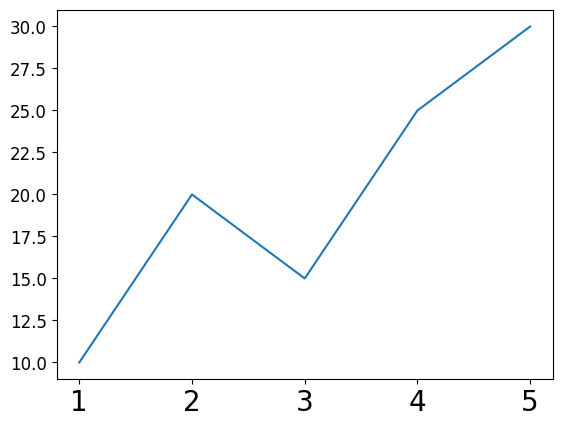

In [2]:
import matplotlib.pyplot as plt

# Create some example data
x = [1, 2, 3, 4, 5]
y = [10, 20, 15, 25, 30]

# Create a plot
plt.plot(x, y)

# Set the size of ticks on the y-axis
plt.tick_params(axis='y', which='major', labelsize=12)  # You can adjust the labelsize parameter
plt.tick_params(axis='x', which='major', labelsize=20)
# Show the plot
plt.show()


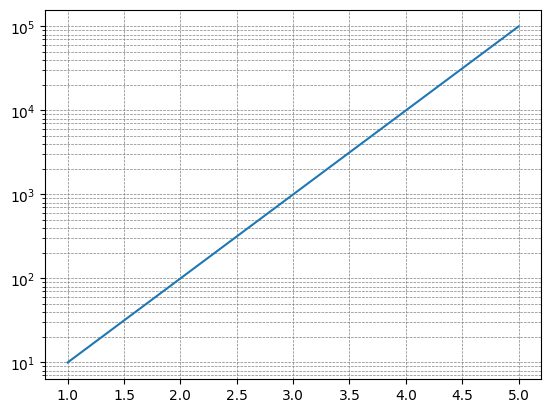

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create some example data
x = np.linspace(1, 5, 100)
y = 10 ** x  # Generating data for a logarithmic scale

# Create a plot with a logarithmic y-axis
plt.plot(x, y)
plt.yscale('log')

# Add logarithmic scale grid lines on the y-axis
plt.grid(which='both', axis='both', linestyle='--', color='gray', linewidth=0.5)

# Show the plot
plt.show()


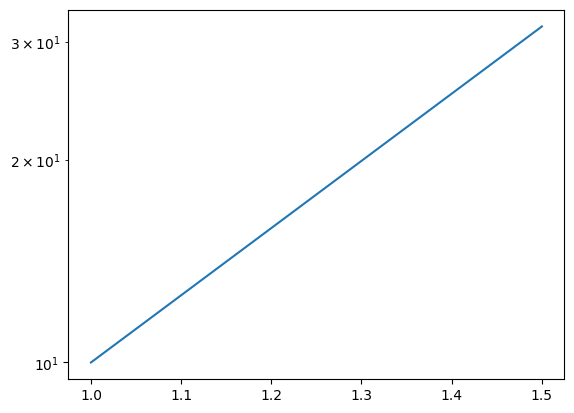

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Create some example data
x = np.linspace(1, 1.5, 100)
y = 10 ** x  # Generating data for a logarithmic scale

# Create a plot with a logarithmic y-axis
plt.plot(x, y)
plt.yscale('log')

# Use ScalarFormatter to display tick values in the y-axis
#plt.gca().yaxis.set_major_formatter(ScalarFormatter())

# Show the plot
plt.show()
